In [ ]:
import tensorflow as tf
import tensorflow_hub as hub

from absl import logging
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import re
import seaborn as sns

In [ ]:
module_url='https://tfhub.dev/google/universal-sentence-encoder/4'
model=hub.load(module_url)
print('module %s loaded' % module_url)

module https://tfhub.dev/google/universal-sentence-encoder/4 loaded


In [ ]:
def embed(i):
  return model(i)

In [ ]:
word="Elephant"
sentence="I am a sentence for which I would like to get its embedding."
paragraph=(
    "Universal Sentence Encoder embeddings also support short paragraphs. "
    "There is no hard limit on how long the paragraph is. Roughly, the longer "
    "the more 'diluted' the embedding will be.")

In [ ]:
type(paragraph)

str

In [ ]:
messages=[word,sentence,paragraph]

# Reduce logging output.
logging.set_verbosity(logging.ERROR)

message_embeddings=embed(messages)

In [ ]:
message_embeddings

<tf.Tensor: shape=(3, 512), dtype=float32, numpy=
array([[ 0.00834449,  0.00048086,  0.06595249, ..., -0.03266348,
         0.02640912, -0.0606688 ],
       [ 0.0508086 , -0.0165243 ,  0.01573782, ...,  0.00976658,
         0.03170123,  0.0178812 ],
       [-0.02833269, -0.05586218, -0.01294143, ..., -0.05133026,
         0.01178871,  0.00579202]], dtype=float32)>

In [ ]:
for i,message_embedding in enumerate(np.array(message_embeddings).tolist()):
  print('Message:{}'.format(messages[i]))
  print("Embedding size:{}".format(len(message_embedding)))
  print('Embedding:{}'.format(message_embeddings[i]))

Semantic Textual Similarity Task Example

In [ ]:
def plot_similarity(labels,features,rotation):
  corr=np.inner(features,features)
  sns.set(font_scale=1.2)
  g=sns.heatmap(corr,xticklabels=labels,yticklabels=labels,
                vmin=0,vmax=1,cmap='YlOrRd')
  g.set_xticklabels(labels,rotation=rotation)

def run_and_plot(messages_):
  message_embeddings_=embed(messages_)
  plot_similarity(messages_,message_embeddings_,90)

Similarity Visualized

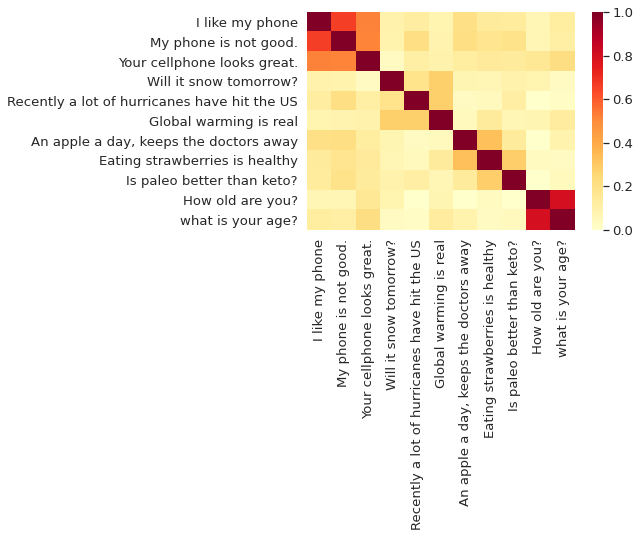

In [ ]:
messages=[
    # Smartphones
    "I like my phone",
    "My phone is not good.",
    "Your cellphone looks great.",

    # Weather
    "Will it snow tomorrow?",
    "Recently a lot of hurricanes have hit the US",
    "Global warming is real",

    # Food and health
    "An apple a day, keeps the doctors away",
    "Eating strawberries is healthy",
    "Is paleo better than keto?",

    # Asking about age
    "How old are you?",
    "what is your age?",
]

run_and_plot(messages)

Evaluation: STS (Semantic Textual Similarity) Benchmark

The STS Benchmark provides an intristic evaluation of the degree to which similarity scores computed using sentence embeddings align with human judgements. The benchmark requires systems to return similarity scores for a diverse selection of sentence pairs. Pearson correlation is then used to evaluate the quality of the machine similarity scores against human judgements.

In [ ]:
import scipy
import math
import csv

sts_dataset=tf.keras.utils.get_file(
    fname='Stsbenchmark.tar.gz',
    origin='http://ixa2.si.ehu.es/stswiki/images/4/48/Stsbenchmark.tar.gz',
    untar=True)

fpath=os.path.join(os.path.dirname(sts_dataset),'stsbenchmark','sts-dev.csv')
sts_dev=pd.read_table(fpath,
                      error_bad_lines=False,
                      skip_blank_lines=True,
                      usecols=[4,5,6],
                      names=['sim','sent_1','sent_2'])
sts_dev=sts_dev.dropna()

In [ ]:
sts_dev.head()

,sim,sent_1,sent_2
0,5.00,A man with a hard hat is dancing.,A man wearing a hard hat is dancing.
1,4.75,A young child is riding a horse.,A child is riding a horse.
2,5.00,A man is feeding a mouse to a snake.,The man is feeding a mouse to the snake.
3,2.40,A woman is playing the guitar.,A man is playing guitar.
4,2.75,A woman is playing the flute.,A man is playing a flute.


In [ ]:
fpath=os.path.join(os.path.dirname(sts_dataset),"stsbenchmark","sts-test.csv")
sts_test=pd.read_table(fpath,
                      error_bad_lines=False,
                      skip_blank_lines=True,
                      quoting=csv.QUOTE_NONE,
                      usecols=[4,5,6],
                      names=['sim','sent_1','sent_2'])

Evaluate Sentence Embeddings

In [ ]:
text=sts_dev[110:120]
text

,sim,sent_1,sent_2
110,0.25,A person is boiling soup.,A woman is placing eggs into a pan.
111,0.00,A woman is dancing.,A man breaks a stick.
112,0.00,A ballet dancer is performing on stage.,The beaver is being petted.
113,0.50,A man shoots a basket.,A man is playing a guitar.
114,0.00,The elephants are bathing.,Two women are singing.
115,0.60,The man cut up an onion.,A man is dancing.
116,4.00,A woman puts cosmetics on her eyelid.,The woman is pencilling on eye shadow.
117,3.40,A woman and man are riding in a car.,A woman driving a car is talking to the man se...
118,0.00,A girl is dancing in a cage.,A onion is being chopped.
119,0.00,A cat is on a robot.,A man is eating bread.


In [ ]:
sts_encode1=tf.nn.l2_normalize(embed([text.iloc[2,1]]),axis=1)
sts_encode2=tf.nn.l2_normalize(embed([text.iloc[2,2]]),axis=1)
cosine_similarities=tf.reduce_sum(tf.multiply(sts_encode1,sts_encode2),axis=1)
clip_cosine_similarities=tf.clip_by_value(cosine_similarities, -1.0, 1.0)
scores=1-tf.acos(clip_cosine_similarities)/math.pi

#print('sts_encode1:',sts_encode1)
#print('sts_encode2:',sts_encode2)
print('similarity score:',text.iloc[2,0])
print('Cosine similarity:',cosine_similarities)
print('Scores:',scores)

similarity score: 0.0
Cosine similarity: tf.Tensor([0.14230952], shape=(1,), dtype=float32)
Scores: tf.Tensor([0.54545283], shape=(1,), dtype=float32)


In [ ]:
sts_encode1=tf.nn.l2_normalize(embed(tf.constant(text['sent_1'].to_list())),axis=1)
sts_encode2=tf.nn.l2_normalize(embed(tf.constant(text['sent_2'].to_list())),axis=1)
cosine_similarities=tf.reduce_sum(tf.multiply(sts_encode1,sts_encode2),axis=1)
clip_cosine_similarities=tf.clip_by_value(cosine_similarities, -1.0, 1.0)
scores=1-tf.acos(clip_cosine_similarities)/math.pi

#print('sts_encode1:',sts_encode1)
#print('sts_encode2:',sts_encode2)
print('Cosine similarity:',cosine_similarities)
print('Scores:',scores)

Cosine similarity: tf.Tensor(
[0.34531045 0.25158    0.14230952 0.39785403 0.18788688 0.11125185
 0.6386131  0.6103774  0.08041349 0.24782655], shape=(10,), dtype=float32)
Scores: tf.Tensor(
[0.61222637 0.58095014 0.54545283 0.630245   0.56016386 0.53548604
 0.7204915  0.7089822  0.5256241  0.5797163 ], shape=(10,), dtype=float32)


In [ ]:
sts_data=sts_dev

def run_sts_benchmark(batch):
  sts_encode1=tf.nn.l2_normalize(embed(tf.constant(batch['sent_1'].to_list())),axis=1)
  sts_encode2=tf.nn.l2_normalize(embed(tf.constant(batch['sent_2'].to_list())),axis=1)
  cosine_similarities=tf.reduce_sum(tf.multiply(sts_encode1,sts_encode2),axis=1)
  clip_cosine_similarities=tf.clip_by_value(cosine_similarities, -1.0, 1.0)
  scores=1-tf.acos(clip_cosine_similarities)/math.pi
  return scores

scores=[]
dev_scores=sts_data['sim'].to_list()
for batch in np.array_split(sts_data,10):
  scores.extend(run_sts_benchmark(batch))

pearson_correlation=scipy.stats.pearsonr(scores,dev_scores)
print('Pearson correlation coeeficient={0}\np_value={1}'.format(
    pearson_correlation[0],pearson_correlation[1]))

Pearson correlation coeeficient=0.8036398551227377
p_value=0.0
